In [50]:
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

## Aim: we want to find patterns in train.csv that help us predict whether the passengers in test.csv survived.

In [96]:
train_data = pd.read_csv('train.csv')  # 891 * 12 (id; survived; ++ pclass;...)
test_data = pd.read_csv('test.csv')    # 418*11 (id;Pclass;name;sex;age; sibsp; parch...)
gender_data = pd.read_csv('gender_submission.csv')  # 418*2 (ID; survived)

In [97]:
train_data.head()
#	PassengerId	Survived;Pclass;Name;Sex;Age;SibSp;Parch;Ticket	Fare;Cabin;Embarked

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [98]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)
print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [99]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)
print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [101]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X_train = pd.get_dummies(train_data[features]); 
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=1)
model.fit(X_train, y)
predictions = model.predict(X_test)

#----------calculate the correction rate---------------
temp = 0
for i in range(418):
    if predictions[i]== gender_data['Survived'][i]:
        temp += 1
correct_pre = temp/len(predictions)
print(correct_pre)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
# output.to_csv('my_submission.csv', index=False)
# print("Your submission was successfully saved!")

0.9784688995215312


In [8]:
## Estimate the performance

## Visualize the data
This is a 12-dimensional description of passager features. How do these dimensions (variables) relate to the survived condition?

Let's start by visualizing our data:

In [38]:
#The final check we want to do is see what data types we have:
df = train_data
df.dtypes
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


## Visualize: encoding categorical values 

In [39]:
## Since we had five types of object data types; we first look the details in it.
df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [40]:
df['Ticket'].value_counts()  # unique length 681
df['Cabin'].value_counts() # unique length 147
df['Name'].value_counts() # unique length 891
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [41]:
# We have already seen that the Sex data only includes male or female and'Embarked'only includes 3 types of values.
# Both are easily translated to valid numbers:
cleanup_map = {'Sex':{'male':0,'female':1},
                'Embarked':{'S':0, 'C':1, 'Q':2} }

df.replace(cleanup_map, inplace=True)


# Before going any further, there are a couple of null values in the data that we need to clean up.
df = df[~df['Age'].isnull() & ~df['Embarked'].isnull()]  


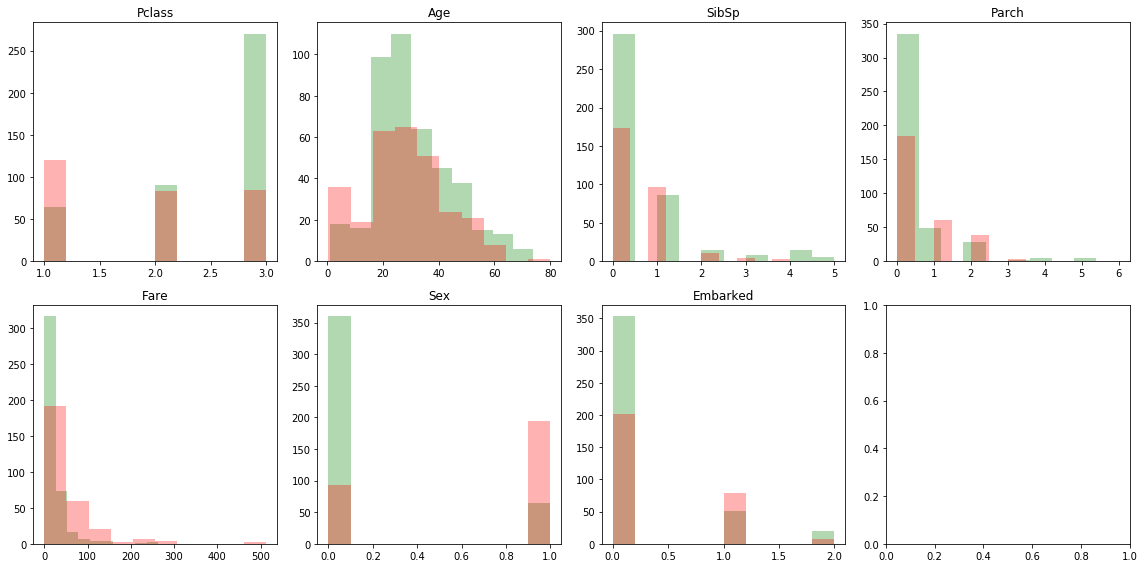

In [44]:

fig, axes = plt.subplots(2,4, figsize=(16,8))
axes = axes.ravel()

colors = {0:'g',1:'r'} 
#<- decide which colors to use for the survived (1=red) and not survived (0=green)

idxs = {}
features = [ "Pclass", "Age", "SibSp", 'Parch','Fare','Sex','Embarked']

for ci in list(set(df['Survived'])): #<- quick way to get all unique items
    subdf = df[df['Survived'] == ci]    
    for j,colj in enumerate(df[features]):
        axes[j].hist(subdf[colj], color=colors[ci], alpha = 0.3)
        axes[j].set_title(colj)
fig.tight_layout()

## Visualize: covariance matrix
We can also plot variables against each other to look for correlations:

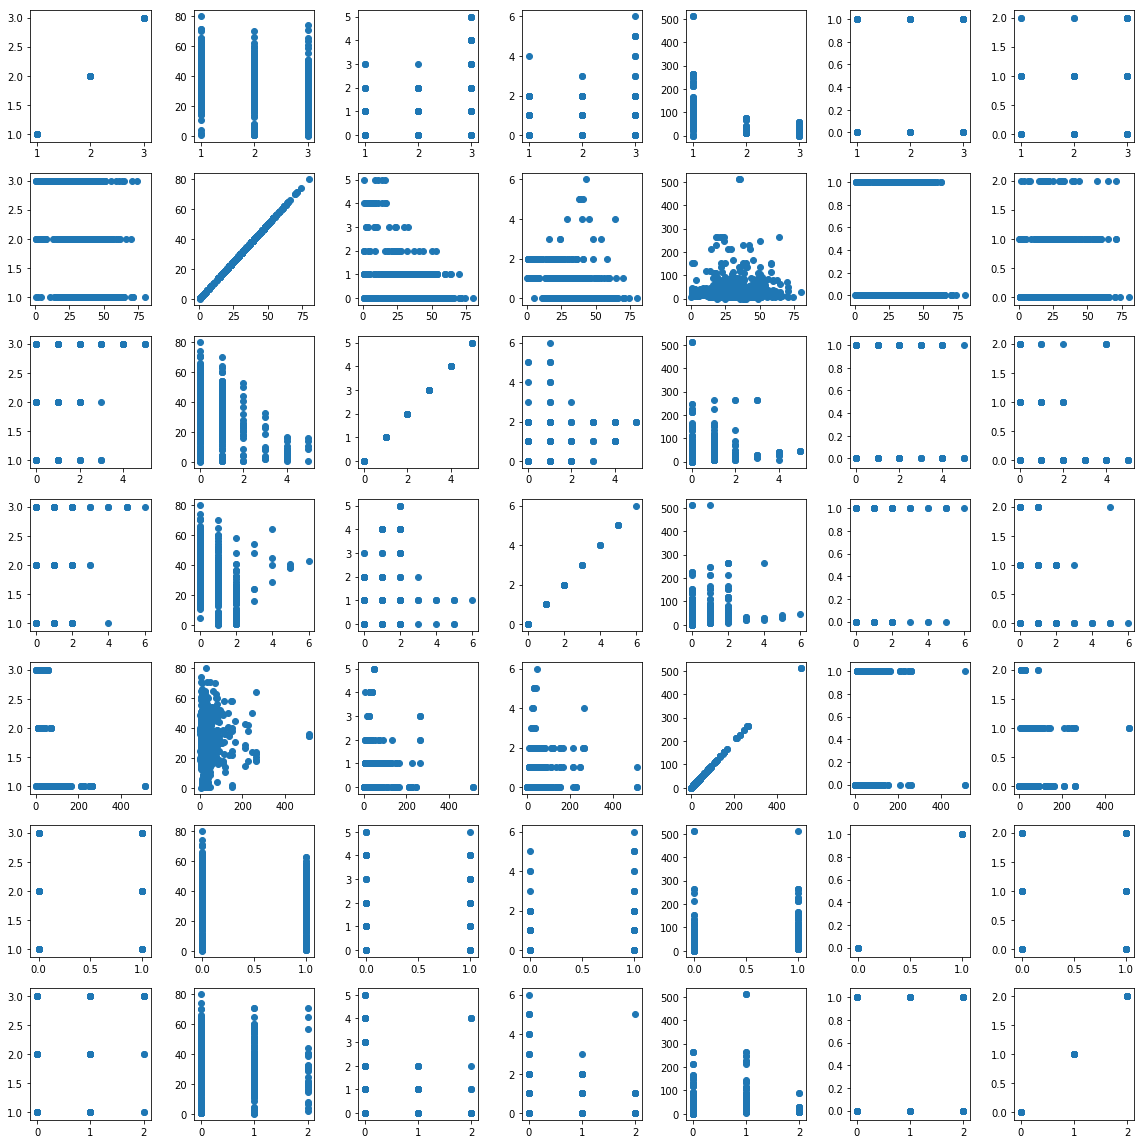

In [45]:
fig, axes = plt.subplots(7,7, figsize = (16,16))
# features = [ "Pclass", "Age", "SibSp", 'Parch','Fare','Sex','Embarked']
for i,coli in enumerate(df[features]):
    for j,colj in enumerate(df[features]):
        axes[i,j].scatter(df[coli], df[colj])

fig.tight_layout()

[ 2.24016854 29.6420927   0.51404494  0.43258427 34.5672514   0.36376404
  0.26123596]


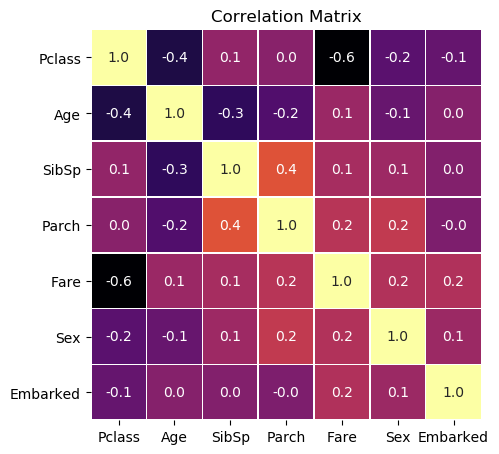

In [46]:
X_orig = df[features].values  # shape: 891*7
X_mean = X_orig.mean(axis = 0)
X_std = X_orig.std(axis=0)

X = (X_orig - X_mean)/X_std  #<- standardize the data

corr_mat = np.corrcoef(X.T)

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
label = [ "Pclass", "Age", "SibSp", 'Parch','Fare','Sex','Embarked']
plot = sns.heatmap(corr_mat.T, square=True, annot=True, fmt='.1f', cbar=False, ax=ax, cmap='inferno', linewidths=.5,
                   xticklabels = label, yticklabels = label)
plot.set_yticklabels(plot.get_yticklabels(), rotation = 0)
ax.set_title('Correlation Matrix')
plt.tight_layout()

## Visualize: Scikit-learn makes this much easier (eg: PCA)

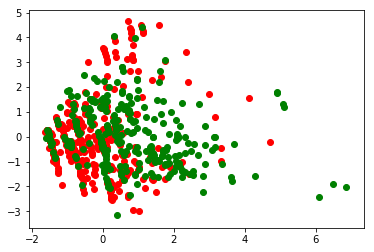

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_2d_skl = pca.fit_transform(X)

fig, ax = plt.subplots()
ax.scatter(X_2d_skl[np.array(df['Survived']==0)][:,0], X_2d_skl[np.array(df['Survived']==0)][:,1] , color = 'r') #<- plot class 1
ax.scatter(X_2d_skl[np.array(df['Survived']==1)][:,0], X_2d_skl[np.array(df['Survived']==1)][:,1] , color = 'g') #<- plot class 2

In [116]:
#We also get the explained variance:
pca.explained_variance_ratio_

array([0.26147067, 0.24839564])

## Model prediction: Random Forest Classifier

In [102]:
test_data = pd.read_csv('test.csv')    # 418*11 (id;Pclass;name;sex;age; sibsp; parch...)
test_data.replace(cleanup_map, inplace=True)
test_data = test_data[~test_data['Age'].isnull() & ~test_data['Embarked'].isnull()]  
X_test = test_data[features]
# print(X_test.head())
print(X_orig)

[[ 3.     22.      1.     ...  7.25    0.      0.    ]
 [ 1.     38.      1.     ... 71.2833  1.      1.    ]
 [ 3.     26.      0.     ...  7.925   1.      0.    ]
 ...
 [ 1.     19.      0.     ... 30.      1.      0.    ]
 [ 1.     26.      0.     ... 30.      0.      1.    ]
 [ 3.     32.      0.     ...  7.75    0.      2.    ]]


In [115]:
from sklearn.ensemble import RandomForestClassifier

y = df['Survived']
features = [ "Pclass", "Age", "SibSp", 'Parch','Fare','Sex']
X_orig = df[features].values

test_data = pd.read_csv('test.csv')    # 418*11 (id;Pclass;name;sex;age; sibsp; parch...)
test_data.replace(cleanup_map, inplace=True)
test_data = test_data.dropna()
X_test = test_data[features].dropna().values
# print(test_data.shape,X_test.shape)

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X_orig, y)

predictions = model.predict(X_test)
# print(predictions.shape,X_test.shape,test_data[features].shape)

#----------calculate the correction rate---------------
temp = 0
for i in range(len(predictions)):
    if predictions[i]== gender_data['Survived'][i]:
        temp += 1
correct_pre = temp/len(predictions)
print(correct_pre)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})

0.4827586206896552


In [109]:
from sklearn.ensemble import RandomForestClassifier

y = df['Survived']
features = [ "Pclass", "Age", "SibSp", 'Parch','Fare','Sex','Embarked']
X_orig = df[features].values

test_data = pd.read_csv('test.csv')    # 418*11 (id;Pclass;name;sex;age; sibsp; parch...)
test_data.replace(cleanup_map, inplace=True)
test_data = test_data.dropna()
X_test = test_data[features].dropna().values
print(test_data.shape,X_test.shape)

model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=1)
model.fit(X_orig, y)

predictions = model.predict(X_test)
# print(predictions.shape,X_test.shape,test_data[features].shape)

#----------calculate the correction rate---------------
temp = 0
for i in range(len(predictions)):
    if predictions[i]== gender_data['Survived'][i]:
        temp += 1
correct_pre = temp/len(predictions)
print(correct_pre)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})

(87, 11) (87, 7)
0.5057471264367817
